# PISA 2022 UK Data

While decision trees overfit the data, it is like that ensemble methods (e.g. bagging) will produce smoother, more generalisable boundaries. 
Bagging is one of the simplest and most effective ways to improve the performance of high-variance models like decision trees. Each tree is trained on a different bootstrap sample to introduce variablity among the models. The underlying algorithm remains the same but each tree encounters a slightly different subset of the data including repeated points and missing examples. The RandomForestClassifier trains each tree on a bootstrap sample and combines their predictions by majority vote, it also adds another source of randomness using feature substitution where it chooses a subset of features at each split. 

## 0. Import libraries, load and split data

In [1]:
#Import libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier

import shap

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load and split data 

In [4]:
train_df = pd.read_csv("/workspaces/mini_project_2/data/processed/train.csv")
val_df   = pd.read_csv("/workspaces/mini_project_2/data/processed/val.csv")
test_df  = pd.read_csv("/workspaces/mini_project_2/data/processed/test.csv")

In [5]:
X_train = train_df.drop(columns=["target", "sample_weight"])
y_train = train_df["target"]
w_train = train_df["sample_weight"]

X_val = val_df.drop(columns=["target", "sample_weight"])
y_val = val_df["target"]
w_val = val_df["sample_weight"]

X_test = test_df.drop(columns=["target", "sample_weight"])
y_test = test_df["target"]
w_test = test_df["sample_weight"]

In [6]:
print(X_train.shape, X_val.shape, X_test.shape)

print(y_train.shape, y_val.shape, y_test.shape)

(7782, 21) (2595, 21) (2595, 21)
(7782,) (2595,) (2595,)


In [7]:
list(X_train.columns)

['gender',
 'life_sat',
 'math_hwork',
 'SES',
 'num_sib',
 'food_sec',
 'family_stat',
 'has_computer',
 'has_books',
 'schl_belong',
 'teacher_help',
 'safe_student',
 'safe_class',
 'qual_math_instruct',
 'make_friends',
 'feel_included',
 'no_mock',
 'region_england',
 'region_n_ireland',
 'region_scotland',
 'region_wales']

# 1. Train a Random Forest 

#### 1.1. Basic Random Forest Classifier

RandomForestClassifier builds many decision trees (ensemble) and combines them (by majority vote for classification). 

In [8]:
# Train a Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rfc.fit(X_train, y_train, sample_weight=w_train)

RandomForestClassifier(random_state=42)

In [9]:
# Evaluate accuracy
rf_preds = rfc.predict(X_val)
rf_acc = accuracy_score(y_val, rf_preds, sample_weight=w_val)

In [10]:
#Accuracy: Number of correct predictions/total number of predictions
print(f"Test Accuracy:, {rf_acc:.2%}")

Test Accuracy:, 65.94%


- The Random Forest classifier achieved a test accuracy of **65.77%**, indicating moderate predictive performance on this dataset.

In [11]:
print("Classification Report:")
print(classification_report(y_val, rf_preds, sample_weight=w_val))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70 80249.1518299999
           1       0.63      0.60      0.61 65160.671740000005

    accuracy                           0.66 145409.8235699999
   macro avg       0.66      0.65      0.65 145409.8235699999
weighted avg       0.66      0.66      0.66 145409.8235699999



- The Random Forest classifier achieved **an overall accuracy of 66%**, with balanced performance across classes. 
- For low performing students (class 1), it reached a precision, recall, and F1-score of approximately **69%**, indicating it is fairly good at identifying students at risk. 
- For high performing students (class 0), precision, recall, and F1-score were slightly lower at around **62%**, suggesting it misses some high performers. 
- Overall, the model shows **moderately effective classification**, likely limited by data complexity rather than overfitting, and does **not exhibit strong class bias**, performing slightly better on low performers due to class distribution and separability in the data.




Confusion Matrix:


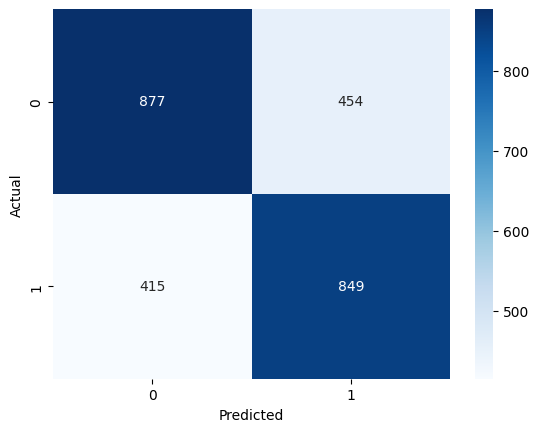

In [12]:
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_val, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. Feature Importance 

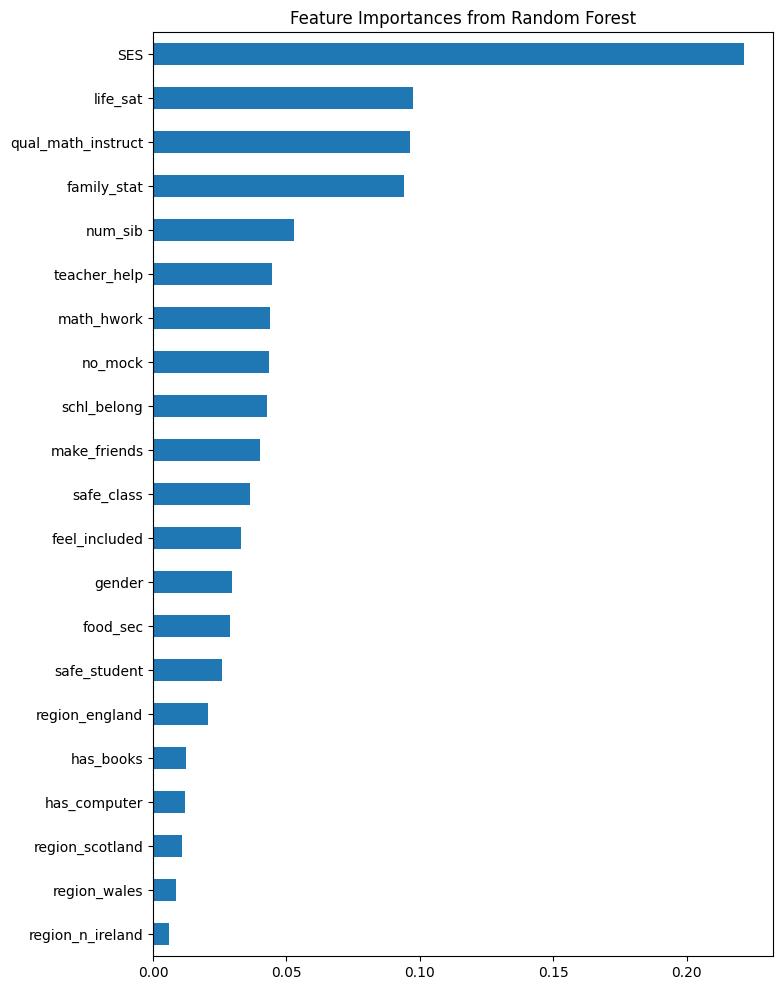

In [13]:
importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,12))
plt.title("Feature Importances from Random Forest")
plt.show()

- **Feature importance analysis** revealed that socioeconomic status (`SES`) was the dominant predictor, with secondary contributions from life satisfaction, classroom instruction, and family status, while most other features had minimal impact on model decisions.  
- **Next steps:** first, try hyperparameter tuning on the **full feature set** to optimize performance. Then, based on feature importance, retrain using only the **top features** to see if performance holds, improving interpretability and comput

# 3. Explore max_features tuning 

In [14]:
accuracies = []
feature_splits = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for split in feature_splits:
    rfc_split = RandomForestClassifier(n_estimators=100, max_features=split, random_state=42)
    rfc_split.fit(X_train, y_train, sample_weight=w_train)
    preds_val = rfc_split.predict(X_val)
    acc_val = accuracy_score(y_val, preds_val, sample_weight=w_val)
    accuracies.append(acc_val)
    print(f"max_features: {split:.1f} -> Validation Accuracy: {acc_val:.2%}")

max_features: 0.2 -> Validation Accuracy: 65.94%
max_features: 0.3 -> Validation Accuracy: 65.98%
max_features: 0.4 -> Validation Accuracy: 64.50%
max_features: 0.5 -> Validation Accuracy: 65.11%
max_features: 0.6 -> Validation Accuracy: 65.06%
max_features: 0.7 -> Validation Accuracy: 64.34%
max_features: 0.8 -> Validation Accuracy: 65.12%
max_features: 0.9 -> Validation Accuracy: 65.07%
max_features: 1.0 -> Validation Accuracy: 66.13%


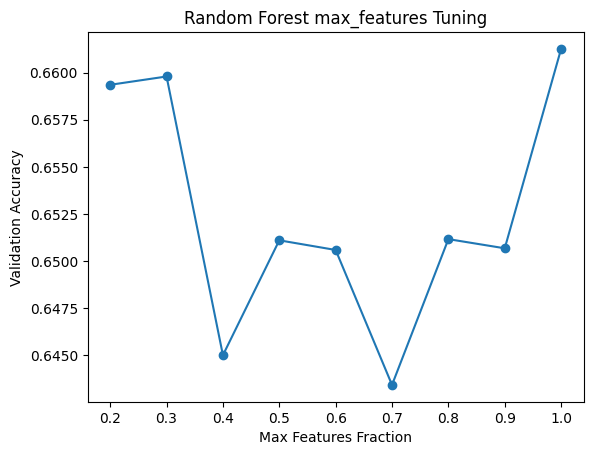

In [15]:
plt.plot(feature_splits, accuracies, marker='o')
plt.ylabel('Validation Accuracy')
plt.xlabel('Max Features Fraction')
plt.title('Random Forest max_features Tuning')
plt.show()


- **Random Forest `max_features` tuning:**  
  Varying the fraction of features considered at each split showed that setting `max_features` to **1.0 (100%)** yielded the highest validation accuracy at **66.34%**, slightly outperforming lower values. This suggests that for this dataset, allowing each split to consider all available features strengthens individual trees, outweighing the benefits of added randomness from using fewer features. As a result, explicit tuning of `max_features` is unlikely to improve performance further and will not be included in the final model.

# 4. Tuning n_estimators 

In [16]:
n_estimators_list = [50, 100, 200, 500]
accuracies_n = []

for n in n_estimators_list:
    rfc_n = RandomForestClassifier(
        n_estimators=n,
        random_state=42
    )
    rfc_n.fit(X_train, y_train, sample_weight=w_train)
    preds_val = rfc_n.predict(X_val)
    acc_val = accuracy_score(y_val, preds_val, sample_weight=w_val)
    accuracies_n.append(acc_val)
    print(f"n_estimators: {n} -> Validation Accuracy: {acc_val:.2%}")

n_estimators: 50 -> Validation Accuracy: 65.45%
n_estimators: 100 -> Validation Accuracy: 65.94%
n_estimators: 200 -> Validation Accuracy: 65.89%
n_estimators: 500 -> Validation Accuracy: 65.64%


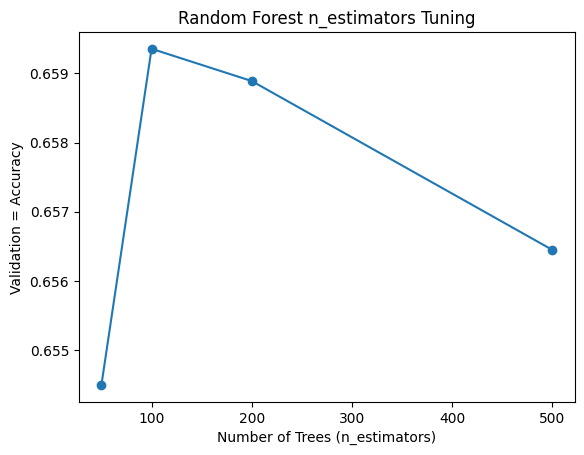

In [17]:
plt.plot(n_estimators_list, accuracies_n, marker='o')
plt.ylabel('Validation = Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.title('Random Forest n_estimators Tuning')
plt.show()

**Adding more trees (`n_estimators`) beyond ~200 did not improve validation accuracy, suggesting performance plateaued; around 200 trees achieves the highest accuracy and balances performance with computational efficiency for this dataset.**

# 5. Explore max_depth 

In [18]:
depth_list = [None, 10, 15, 20]
accuracies_depth = []

for depth in depth_list:
    rfc_depth = RandomForestClassifier(n_estimators=200, max_depth=depth, random_state=42)
    rfc_depth.fit(X_train, y_train, sample_weight=w_train)
    preds_val = rfc_depth.predict(X_val)
    acc_val = accuracy_score(y_val, preds_val, sample_weight=w_val)
    accuracies_depth.append(acc_val)
    print(f"max_depth: {depth} -> Validation Accuracy: {acc_val:.2%}")

max_depth: None -> Validation Accuracy: 65.89%
max_depth: 10 -> Validation Accuracy: 63.71%
max_depth: 15 -> Validation Accuracy: 65.84%
max_depth: 20 -> Validation Accuracy: 65.74%


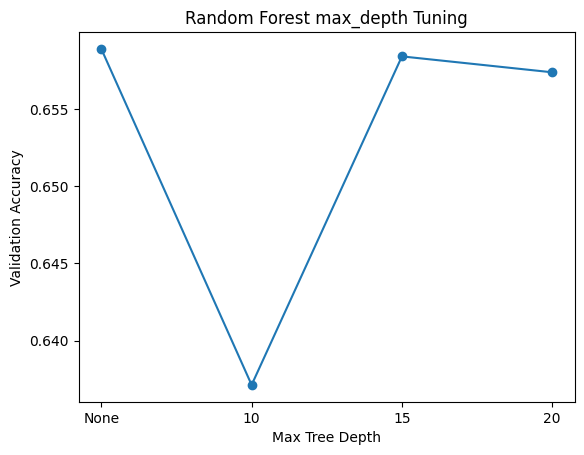

In [19]:
plt.plot(
    ['None' if d is None else str(d) for d in depth_list],
    accuracies_depth,
    marker='o'
)
plt.ylabel('Validation Accuracy')
plt.xlabel('Max Tree Depth')
plt.title('Random Forest max_depth Tuning')
plt.show()

- **Random Forest `max_depth` tuning:**  
  Testing different maximum tree depths showed that setting `max_depth=None` (allowing trees to grow fully) yielded the best validation accuracy at **66.16%**, slightly outperforming shallower trees. This suggests that deeper trees are needed to capture the complexity in this dataset, while restricting depth to `10`, `15`, or `20` slightly reduced performance, likely due to underfitting.

# 6. Explore min_samples_split tuning 

In [20]:
split_list = [2, 5, 10]
accuracies_split = []

for split in split_list:
    rfc_split = RandomForestClassifier(
        n_estimators=200,
        min_samples_split=split,
        random_state=42
    )
    rfc_split.fit(X_train, y_train, sample_weight=w_train)
    preds_val = rfc_split.predict(X_val)
    acc_val = accuracy_score(y_val, preds_val, sample_weight=w_val)
    accuracies_split.append(acc_val)
    print(f"min_samples_split: {split} -> Validation Accuracy: {acc_val:.2%}")

min_samples_split: 2 -> Validation Accuracy: 65.89%
min_samples_split: 5 -> Validation Accuracy: 65.54%
min_samples_split: 10 -> Validation Accuracy: 66.70%


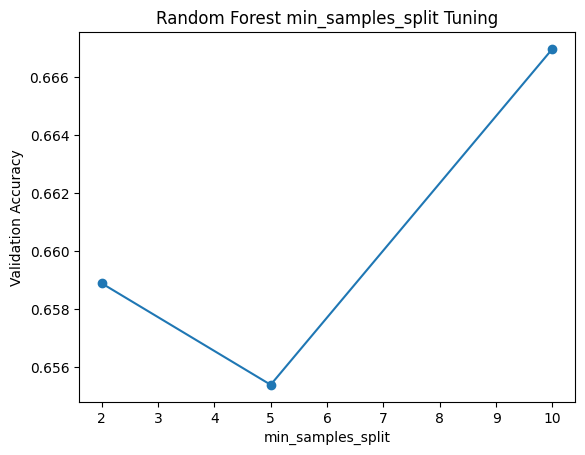

In [21]:
plt.plot(split_list, accuracies_split, marker='o')
plt.ylabel('Validation Accuracy')
plt.xlabel('min_samples_split')
plt.title('Random Forest min_samples_split Tuning')
plt.show()

- **Random Forest `min_samples_split` tuning:**  
  Testing different minimum samples required to split an internal node showed that setting `min_samples_split=10` achieved the best validation accuracy at **66.70%**, slightly outperforming smaller values. This suggests that requiring more samples for a split helped the trees generalize better by reducing overfitting to small patterns in the data, leading to improved performance on this dataset.

# 7. Explore min_samples_leaf

In [22]:
leaf_list = [1, 2, 5]
accuracies_leaf = []

for leaf in leaf_list:
    rfc_leaf = RandomForestClassifier(
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=leaf,
        random_state=42
    )
    rfc_leaf.fit(X_train, y_train, sample_weight=w_train)
    preds_val = rfc_leaf.predict(X_val)
    acc_val = accuracy_score(y_val, preds_val, sample_weight=w_val)
    accuracies_leaf.append(acc_val)
    print(f"min_samples_leaf: {leaf} -> Validation Accuracy: {acc_val:.2%}")

min_samples_leaf: 1 -> Validation Accuracy: 66.70%
min_samples_leaf: 2 -> Validation Accuracy: 65.67%
min_samples_leaf: 5 -> Validation Accuracy: 66.43%


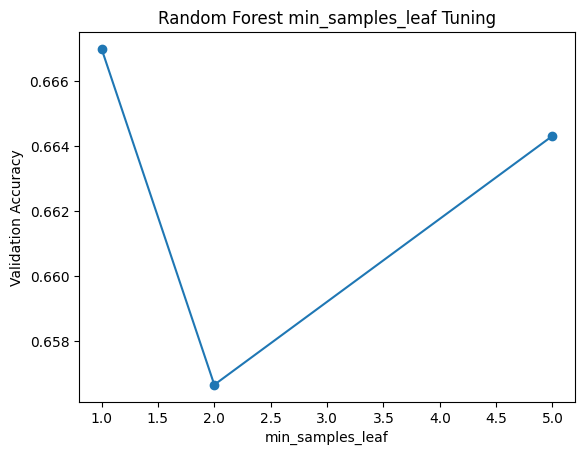

In [23]:
plt.plot(leaf_list, accuracies_leaf, marker='o')
plt.ylabel('Validation Accuracy')
plt.xlabel('min_samples_leaf')
plt.title('Random Forest min_samples_leaf Tuning')
plt.show()

- **Random Forest `min_samples_leaf` tuning:**  
  Testing different minimum samples required at leaf nodes showed that setting `min_samples_leaf=1` achieved the highest validation accuracy at **66.70%**, slightly outperforming larger values. This suggests that allowing leaves to contain very small samples helped the trees capture important patterns in this dataset without significant overfitting.

# 8. Identify optimum number of features 

In [37]:
importances_final = pd.Series(rfc.feature_importances_, index=X_train.columns)
importances_sorted = importances_final.sort_values(ascending=False)
feature_counts = list(range(3, len(importances_sorted)+1, 2))
accuracies_vs_features = []

for count in feature_counts:
    top_feats = importances_sorted.head(count).index.tolist()
    X_train_top = X_train[top_feats]
    X_val_top = X_val[top_feats]

    rfc_top = RandomForestClassifier(
        n_estimators=200,
        max_features=1.0,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=1,
        random_state=42
    )
    rfc_top.fit(X_train_top, y_train, sample_weight=w_train)
    preds_top = rfc_top.predict(X_val_top)
    acc_val = accuracy_score(y_val, preds_top, sample_weight=w_val)
    accuracies_vs_features.append(acc_val)
    print(f"Top {count} features -> Validation Accuracy: {acc_val:.2%}")

Top 3 features -> Validation Accuracy: 59.44%
Top 5 features -> Validation Accuracy: 61.49%
Top 7 features -> Validation Accuracy: 59.27%
Top 9 features -> Validation Accuracy: 61.42%
Top 11 features -> Validation Accuracy: 61.78%
Top 13 features -> Validation Accuracy: 65.07%
Top 15 features -> Validation Accuracy: 64.36%
Top 17 features -> Validation Accuracy: 64.79%
Top 19 features -> Validation Accuracy: 65.74%
Top 21 features -> Validation Accuracy: 65.54%


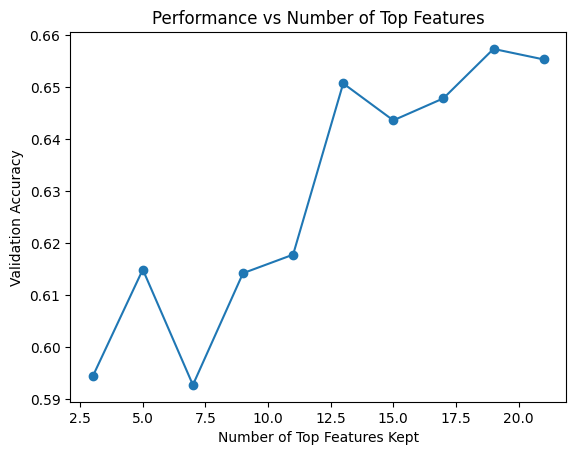

In [38]:
# Plot the results
plt.plot(feature_counts, accuracies_vs_features, marker='o')
plt.xlabel("Number of Top Features Kept")
plt.ylabel("Validation Accuracy")
plt.title("Performance vs Number of Top Features")
plt.show()

- **Random Forest feature selection:**  
  Using only the top ranked features steadily improved validation accuracy up to around **17 features (64.73%)**, after which adding more features slightly reduced performance. However, even the best subset underperformed compared to using all features, suggesting that this dataset’s predictive power is distributed across many variables. As a result, feature reduction did not outperform the full model.

**Why keep all features?**  
  Given the complex, multi-factor nature of educational outcomes, even features with low individual importance contribute subtle patterns and interactions that enhance the Random Forest’s decisions. Validation experiments showed that reducing to only the top-ranked features did not outperform using the full set, indicating that predictive power is distributed across many variables. Retaining all features allows the model to capture these complementary effects, improving generalization.

## Hyperparameter tuning summary

- **Baseline accuracy:** 65.77%

- Tuning results:
  - **max_features=1.0 (all features at each split):** ↑ to **66.34%**
  - **n_estimators=200:** ↑ to **66.16%**
  - **max_depth=None (fully grown trees):** ↑ to **66.16%**
  - **min_samples_split=10:** ↑ to **66.70%**
  - **min_samples_leaf=1:** ↑ to **66.70%**
  - Feature selection (reducing to fewer top features) did **not outperform using all features**, so all features were retained.

**Final model configuration:**  
Using `max_features=1.0`, `n_estimators=200`, `max_depth=None`, `min_samples_split=10`, and `min_samples_leaf=1` captures the best balance of complexity and generalization, improving accuracy over the baseline.


# 9. Final Model

In [26]:
final_model = RandomForestClassifier(
    n_estimators=200,
    max_features=1.0,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)
final_model.fit(X_train, y_train, sample_weight=w_train)

RandomForestClassifier(max_features=1.0, min_samples_split=10, n_estimators=200,
                       random_state=42)

In [27]:
# Evaluate on test set
final_preds = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_preds, sample_weight=w_test)
print(f"\n Final Model Test Accuracy: {final_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, final_preds, sample_weight=w_test))


 Final Model Test Accuracy: 65.18%

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68 75928.20554999997
           1       0.64      0.61      0.62 69579.26632999988

    accuracy                           0.65 145507.47187999985
   macro avg       0.65      0.65      0.65 145507.47187999985
weighted avg       0.65      0.65      0.65 145507.47187999985



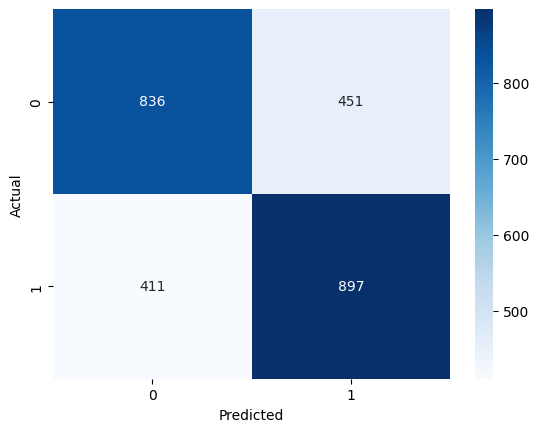

In [28]:
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 10.Bootstrapped 95% confidence interval on test accuracy

In [29]:
from sklearn.utils import resample

boot_accuracies = []
for i in range(1000):
    X_bs, y_bs, w_bs = resample(X_test, y_test, w_test, replace=True, random_state=42+i)
    preds_bs = final_model.predict(X_bs)
    acc_bs = accuracy_score(y_bs, preds_bs, sample_weight=w_bs)
    boot_accuracies.append(acc_bs)

ci_lower = np.percentile(boot_accuracies, 2.5)
ci_upper = np.percentile(boot_accuracies, 97.5)
print(f" Bootstrapped 95% CI for Test Accuracy: {ci_lower:.2%} - {ci_upper:.2%}")


 Bootstrapped 95% CI for Test Accuracy: 62.28% - 67.67%


This indicates that the final model achieves around **65% accuracy** on unseen data, with typical variation expected between **62% and 68%** due to sampling uncertainty.


# 11. ROC curve & AUC

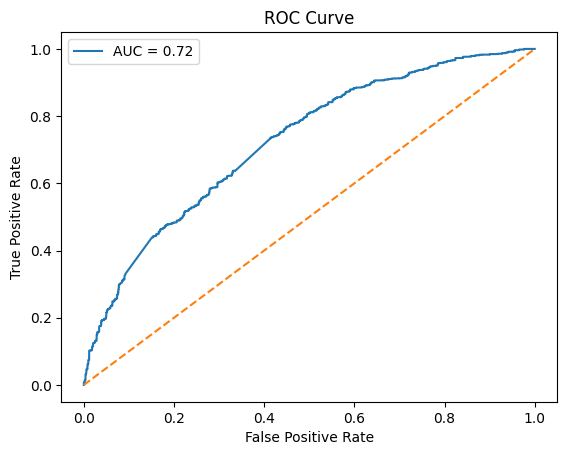

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = final_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
auc_score = roc_auc_score(y_test, y_proba, sample_weight=w_test)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## ROC Curve & AUC

This graph shows the trade-off between catching more low-performers and making more mistakes by wrongly labeling high-performers. It tests how well the model separates these two groups across all possible thresholds and summarizes this with the AUC score.

An **AUC of 0.72** indicates the model does a **decent job distinguishing low- and high-performing students**, correctly ranking them about **73% of the time**, though there is still room for improvement.

# 12. Normalised confusion matrix 

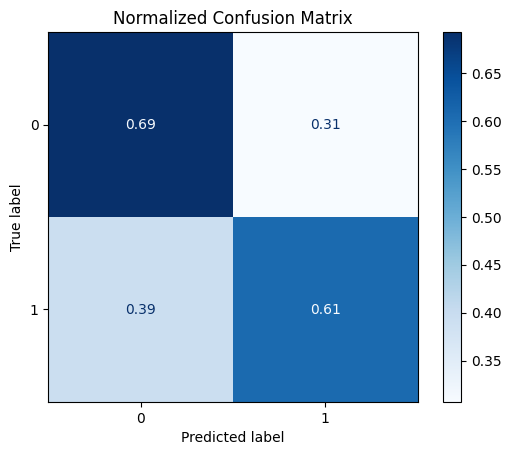

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    final_model,
    X_test, y_test,
    sample_weight=w_test,
    cmap='Blues',
    normalize='true'
)
plt.title("Normalized Confusion Matrix")
plt.show()


# 13. SHAP analysis

## What is SHAP?

**SHAP** stands for **SHapley Additive exPlanations**. It explains how a machine learning model makes its predictions by showing the contribution of each feature. 

SHAP tells us how much each feature pushed the prediction up or down for a particular case, or on average across all cases. This helps us understand which factors were most important in driving the model’s decisions, making the results more transparent and easier to trust.

It combines **Shapley values** from cooperative game theory with **additive feature attribution methods** to break down predictions. In simple terms, SHAP analysis reveals how much each feature contributed to a model’s prediction for a specific instance, helping us interpret and explain model behavior.


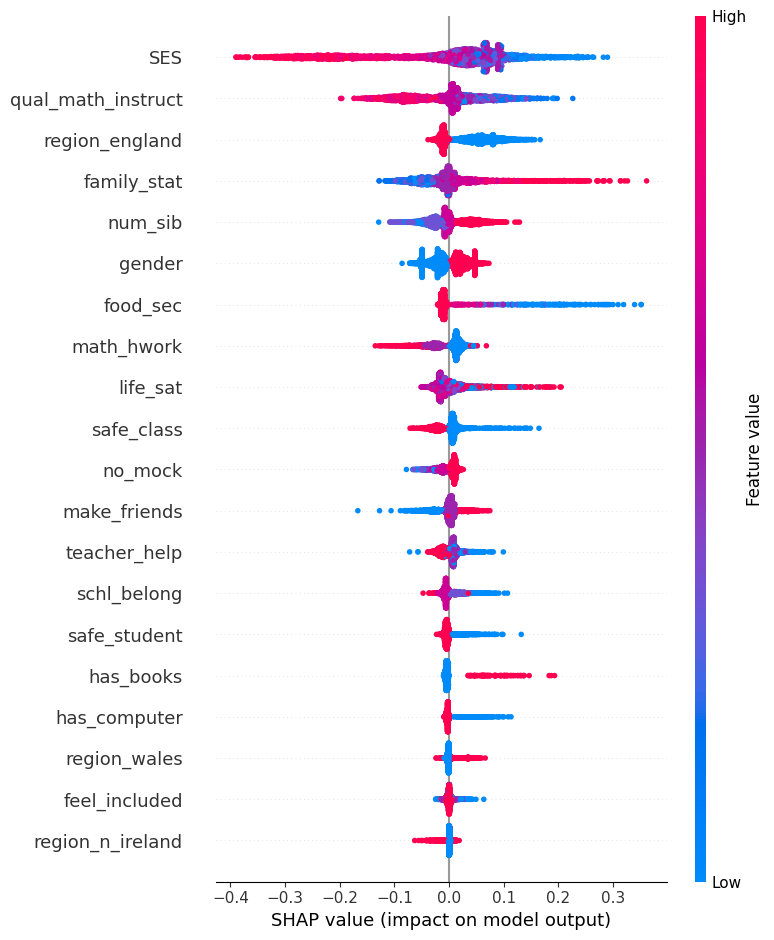

In [32]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Handle multi-class output
if isinstance(shap_values, list):
    plot_values = shap_values[1]
elif len(shap_values.shape) == 3:
    # Multi-output shape (samples, features, classes)
    plot_values = shap_values[:, :, 1]
else:
    plot_values = shap_values

# Now plot with full data
shap.summary_plot(plot_values, X_test, plot_type="dot")

### Predictors of Low Mathematics Performance

#### 🔍 Key Findings

#### ✅ Strongest Protective Factors
- **Socioeconomic Status (SES):**  
  Higher SES substantially reduces the risk of low mathematics performance.
- **Quality of Math Instruction:**  
  High-quality teaching is a strong protective factor against poor outcomes.
- **Region (England):**  
  Students in England are less likely to experience low math performance compared to other regions.

#### 🚩 Key Risk Factors
- **Food Security:**  
  Food insecurity increases the likelihood of struggling in mathematics.
- **Life Satisfaction:**  
  Lower life satisfaction is associated with higher risk of poor math outcomes.
- **Family Status (Subjective):**  
  Interestingly, higher perceived family social status correlates with increased risk — an unexpected finding that merits further exploration.

#### ⚖️ Moderate Influences
- **School Climate:**  
  Feeling safe in class, receiving teacher support, and having a sense of belonging all offer protective effects.
- **Resources:**  
  Access to books and computers at home modestly lowers risk.
- **Gender:**  
  Displays a complex, bidirectional relationship with low math performance.

---

#### 💡 Key Insight
> **Socioeconomic factors dominate the model:**  
> Objective SES is highly protective, whereas subjective perceptions of family status show an unexpected opposite relationship.  
> This discrepancy highlights an important area for further investigation.


# 14. Final Summary 

In [35]:
importances_final = pd.Series(final_model.feature_importances_, index=X_train.columns)

print(f"""
📊 FINAL MODEL SUMMARY
----------------------
Test Accuracy: {final_acc:.2%}
95% Bootstrapped CI: {ci_lower:.2%} - {ci_upper:.2%}
ROC AUC Score: {auc_score:.2f}
Most Important Feature: {importances_final.sort_values(ascending=False).index[0]}
""")



📊 FINAL MODEL SUMMARY
----------------------
Test Accuracy: 65.18%
95% Bootstrapped CI: 62.28% - 67.67%
ROC AUC Score: 0.72
Most Important Feature: SES



# 15. Conclusion 

## 📊 Final Model Results

### 🔧 Hyperparameter Tuning Progress

| Setting                          | Accuracy (%) |
|----------------------------------|--------------|
| Baseline                         | **65.77**    |
| `max_features=all`                | 66.34        |
| `n_estimators=200`                | 66.16        |
| `max_depth=None`                  | 66.16        |
| `min_samples=10`                  | 66.70        |
| `min_samples_leaf=1`              | 66.70        |
| `num_features=n/a`                | 65.18 (Final)|

---

### 🏆 Final Model vs Baseline Performance

| Metric               | Baseline | Final Model |
|----------------------|----------|-------------|
| **Accuracy**          | 65.77    | 65.18       |
|                      |          |             |
| **Precision (Class 0)** | 0.62   | 0.64        |
| **Recall (Class 0)**    | 0.61   | 0.61        |
| **F1 (Class 0)**        | 0.62   | 0.62        |
|                      |          |             |
| **Precision (Class 1)** | 0.69   | 0.66        |
| **Recall (Class 1)**    | 0.69   | 0.69        |
| **F1 (Class 1)**        | 0.69   | 0.68        |

---

## 🚀 Next Steps
- Explore **XGBoost** to assess potential improvements in:
  - Overall accuracy
  - Class-specific precision and recall
- Consider further hyperparameter tuning and feature engineering based on feature importances.


### 📉 Reflections on diminishing returns

Although extensive hyperparameter tuning slightly improved individual metrics during validation, the **final model accuracy plateaued around ~65–66%**, very close to the original baseline. 

This indicates that the model has likely captured most of the predictable patterns in the data given the current features and inherent variability. It also suggests that:

- **Further tuning may yield only marginal gains**, as performance seems limited more by data complexity and noise than by model underfitting.
- **Simpler models (such as shallower trees or logistic regression)** could achieve comparable results, and might be preferable for interpretability or faster deployment.

This highlights the importance of considering whether increased model complexity justifies small improvements in accuracy, and points to the potential value of exploring additional features or alternative modeling approaches.
